#### Notebook `Data Preprocessing`

#### Group:
- `Miguel Matos - 20221925`
- `André Nicolau - 20221861`
- `André Ferreira - 20250398`

---

#### <font> Table of Contents </font> <a class="anchor" id='toc'></a> 
1. [Imports](#Imports)
2. [Data Preprocessing](#data-preprocessing)

- 2.1. [Missing Values](#missing-values)
- 2.2. [Outliers](#outliers)
- 2.3. [Encoding Categorical Variables](#encoding-categorical-variables)
- 2.4. [Feature Engeneering](#feature-engeneering)


----

# Imports
[Back to TOC](#toc)

In [1]:
from functions import *

In [2]:
data = pd.read_csv("../data/data_cleaned.csv", index_col= "carID")
pd.set_option("display.max_columns", None)

# Data Preprocessing

Now, we want to split the data, and use "Brand" to stratify the data. For that, we need to make sure there are no missing values on "Brand".

In [3]:
data.isna().sum()

Brand              236
model             1517
car_age           1491
price                0
transmission      1522
mileage           1832
fuelType          1515
tax               8282
mpg               7962
engineSize        1780
paintQuality%     1891
previousOwners    1921
dtype: int64

As there are only 236 rows in "Brand" with missing values, and we want to use "Brand" to stratify the data, we'll delete these rows.

In [4]:
data.dropna(subset=["Brand"], inplace=True)

Let's splitt the data now.

In [5]:
cars_data = data.drop("price", axis = 1)
target_data = data["price"]

In the following cell, we'll split the data into 70% for train and 30% for test, as we have a big amount of data (around 75k rows).


In [6]:
X_train, X_val, y_train, y_val = train_test_split(cars_data, target_data, 
                                                    test_size= 0.3, 
                                                    random_state= 7, # 7 because of Ronaldo :)
                                                    shuffle= True, # True, because the data is ordered by brands
                                                    stratify = cars_data["Brand"])

In [7]:
print(f"The length of the training data is {len(X_train)}.")
print(f"The length of the validation data is {len(X_val)}.")

The length of the training data is 53015.
The length of the validation data is 22722.


## Missing Values
[Back to TOC](#toc)

### Impute Numerical

In [8]:
metric_features = ["car_age", "mileage", "engineSize", "paintQuality%", "previousOwners", "tax", "mpg"]

In [9]:
#Here we are scaling for each brand 

imputer = KNNImputer(n_neighbors=5, weights="uniform")


imputed_list = [] #to store the imputed results


for brand, df_brand in X_train.groupby("Brand"):

    df_temporary = df_brand.copy() #so that we don't modify the original

    scaler = StandardScaler() #Define the Scaler

    scaled_data = scaler.fit_transform(df_temporary[metric_features]) #Scale an transform the data

    imputed_scaled = imputer.fit_transform(scaled_data)  #Apply KNN imputer on scaled data

    df_temporary[metric_features] = scaler.inverse_transform(imputed_scaled) #Reverse scaling

    imputed_list.append(df_temporary) # Adding each dataframe to our imputed_list


X_train = pd.concat(imputed_list, axis=0)   # Combine all brands again
X_train = X_train.loc[X_train.index]  # restore original order

In [10]:
X_train.isna().sum()

Brand                0
model             1069
car_age              0
transmission      1056
mileage              0
fuelType          1086
tax                  0
mpg                  0
engineSize           0
paintQuality%        0
previousOwners       0
dtype: int64

### Impute Categorical

In [11]:
non_metric_features = ["model", "transmission", "fuelType"]

In [12]:
for col in non_metric_features:
    mode_value = X_train[col].mode()[0]
    X_train[col] = X_train[col].fillna(mode_value)

In [13]:
X_train.isna().sum()

Brand             0
model             0
car_age           0
transmission      0
mileage           0
fuelType          0
tax               0
mpg               0
engineSize        0
paintQuality%     0
previousOwners    0
dtype: int64

## Outliers
[Back to TOC](#toc)

Firstly, let's visualize the data distribution of our trainning data.

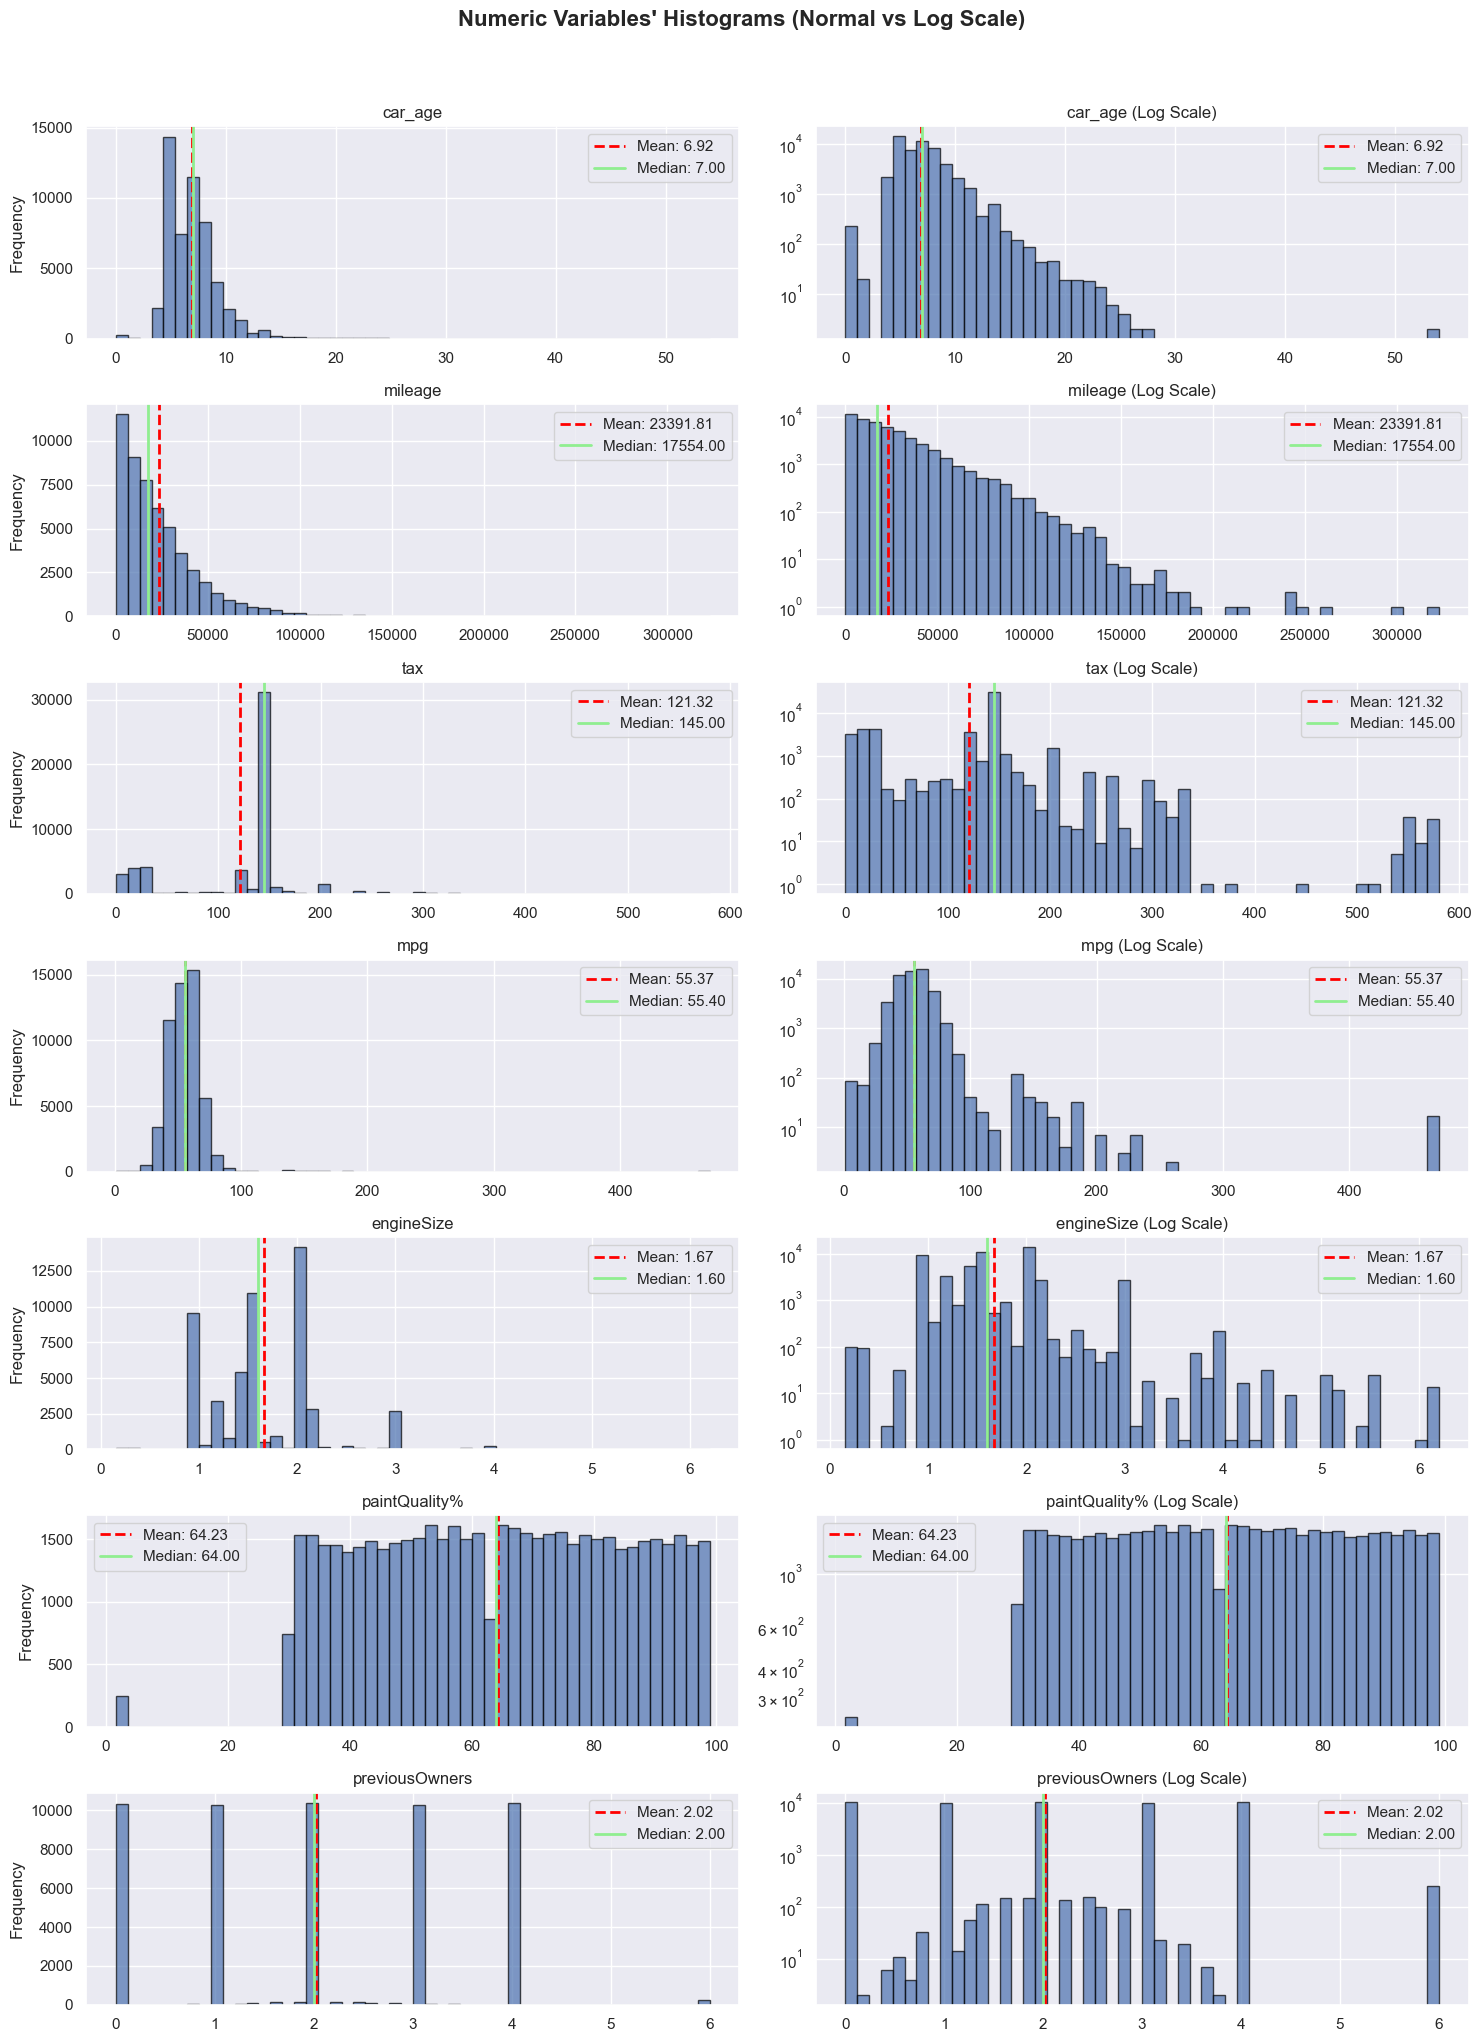

In [14]:
# Plot ALL Numeric Variables' Histograms in one figure
sns.set(style= "darkgrid")

metric_features = X_train.select_dtypes(include=np.number)

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(7, 2, figsize=(15, 20))

# Loop through each feature
for i, feat in enumerate(metric_features):

    # Calculate mean and median
    mean_val = X_train[feat].mean()
    median_val = X_train[feat].median()
    
    # Left plot: normal histogram
    axes[i, 0].hist(X_train[feat], bins = 50, edgecolor= "black", alpha = 0.7)
    axes[i, 0].set_title(f"{feat}")
    axes[i, 0].set_ylabel("Frequency")
    axes[i, 0].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    axes[i, 0].axvline(median_val, color='lightgreen', linestyle='-', linewidth=2, label=f'Median: {median_val:.2f}')
    axes[i, 0].legend()

    # Right plot: log-scale histogram
    axes[i, 1].hist(X_train[feat], bins= 50, log = True, edgecolor= "black", alpha = 0.7)
    axes[i, 1].set_title(f"{feat} (Log Scale)")
    axes[i, 1].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    axes[i, 1].axvline(median_val, color='lightgreen', linestyle='-', linewidth=2, label=f'Median: {median_val:.2f}')
    axes[i, 1].legend()

# Adjust layout and add overall title
fig.suptitle("Numeric Variables' Histograms (Normal vs Log Scale)", fontsize=16, y=1.02, fontweight='bold')
plt.tight_layout()
plt.show()

In [15]:
X_train.loc[X_train["car_age"] > 30]

,Brand,model,car_age,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners
carID,,,,,,,,,,,
35769,Mercedes,M class,54.0,Automatic,14000.0,Diesel,305.0,39.2,1.92,44.0,3.0
62732,Opel,Zafira,54.0,Manual,37357.0,Petrol,200.0,42.2,1.52,60.0,2.0


As the number of cars with age superior to 30 is only 2, and both have 54 years, we will cap them to the superior limit before these two cases.

In [16]:
X_train.loc[X_train["car_age"] > 30, "car_age"] = X_train.loc[X_train["car_age"] < 30, "car_age"].max()

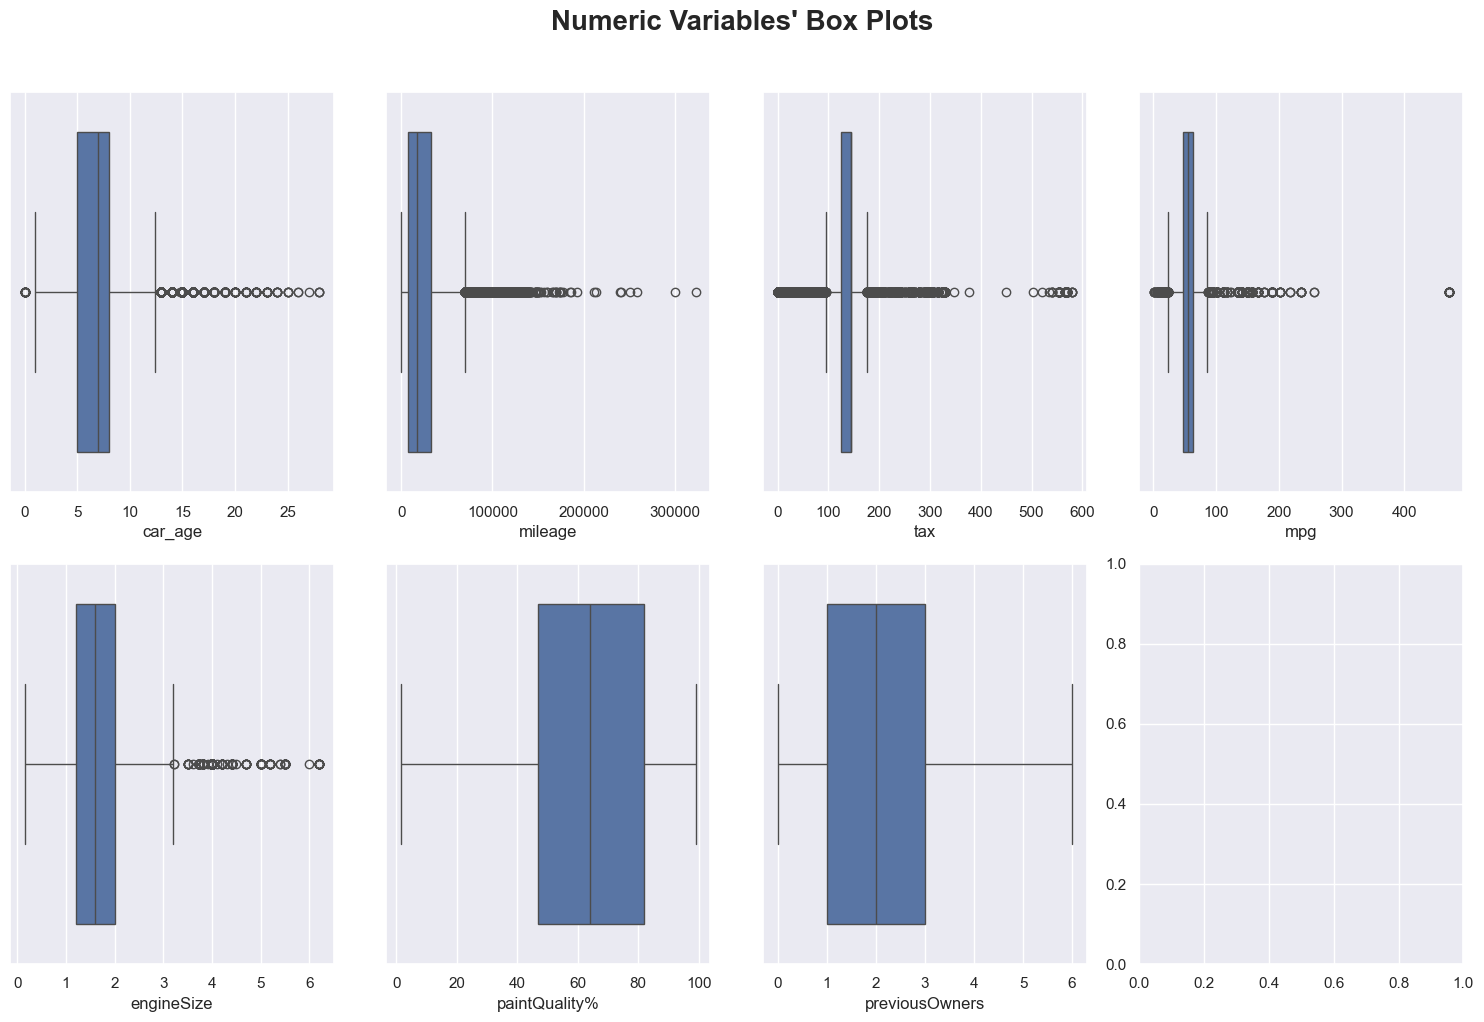

In [17]:
metric_features = X_train.select_dtypes(include=np.number)
boxplotter(X_train, metric_features, n_rows=2, n_cols=4)

With the visualization of both histograms and boxplots, we conclude that the variables where outliers will be removed are:
- "tax" and "mpg": All outliers will be removed

- The variable "engineSize" will not have the outliers removed, as the high values of engine Size are related to the most expansive brands, and doing so, would mean cutting out mostly the top 3 most expansive brands: "Audi", "BMW", and "Mercedes".

As the refered distributions are really skewed and the dataset is large, we'll use the IQR(Interquartil range) method to cap the outliers.

In [18]:
outliers_col = ["car_age", "mileage", "tax", "mpg"]

for col in outliers_col:

    if col == "car_age" or col == "mileage":
        q_1 = X_train[col].quantile(0.25)
        q_3 = X_train[col].quantile(0.75)
        IQR = q_3 - q_1
        X_train[col] = np.clip(X_train[col], q_1 - 3 * IQR , q_3 + 3 * IQR) # Only severe outliers capped
        
    else:
        q_1 = X_train[col].quantile(0.25)
        q_3 = X_train[col].quantile(0.75)
        IQR = q_3 - q_1
        X_train[col] = np.clip(X_train[col], q_1 - 1.5 * IQR , q_3 + 1.5 * IQR)

Let's plot the variables distributions again.

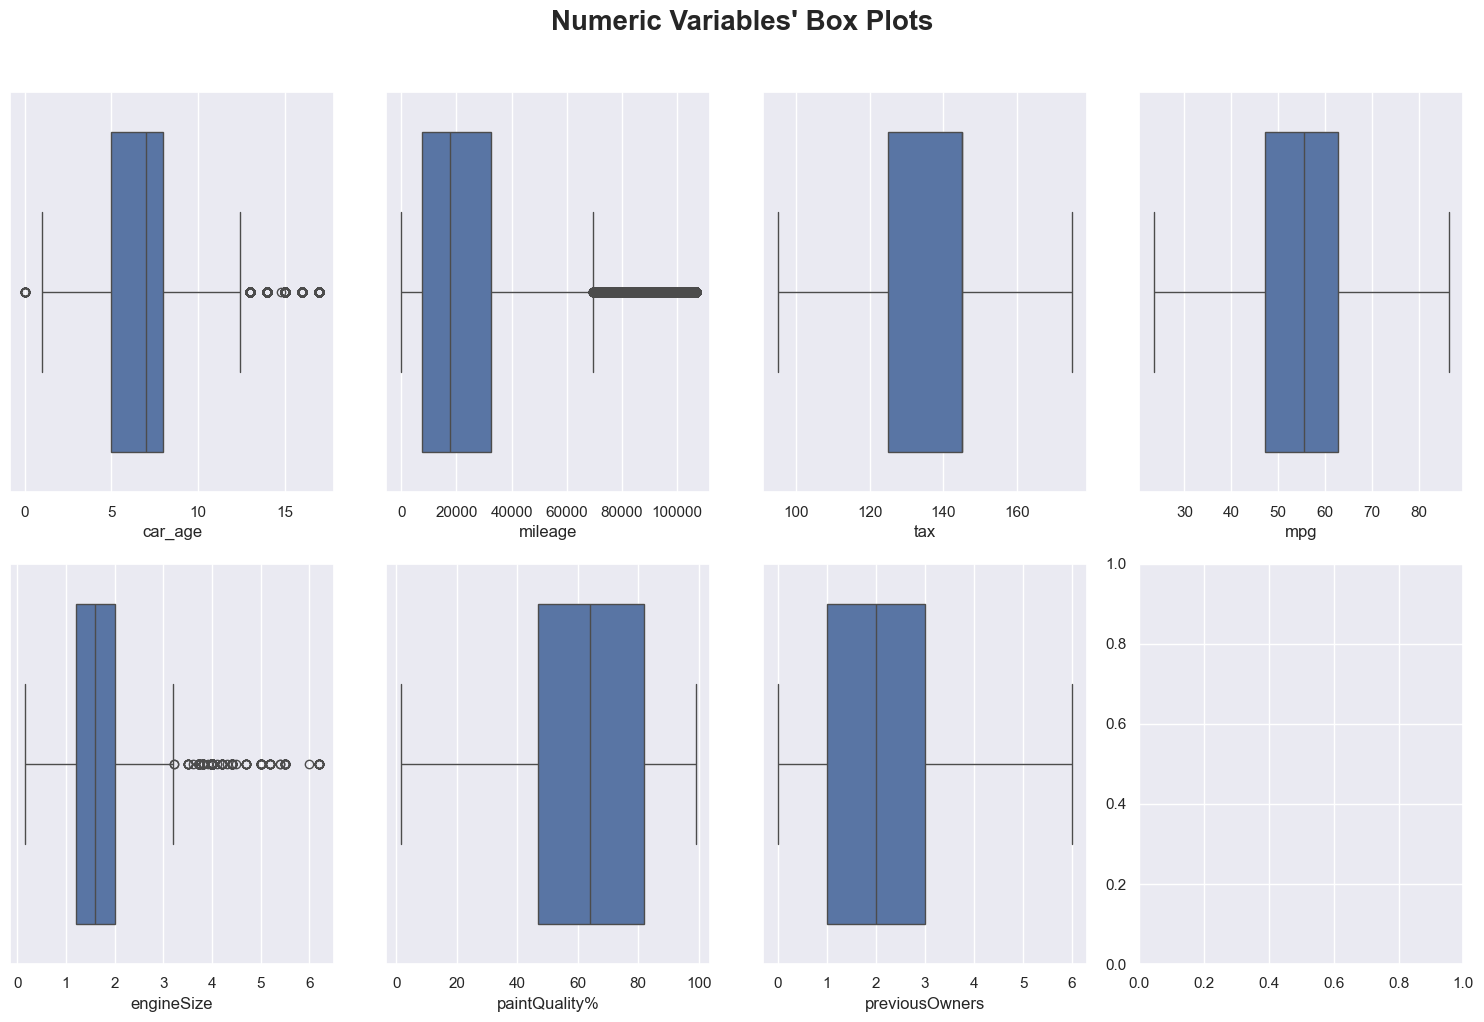

In [19]:
boxplotter(X_train, metric_features, n_rows=2, n_cols=4)

Now let's take a look to possible multidimensional outliers.

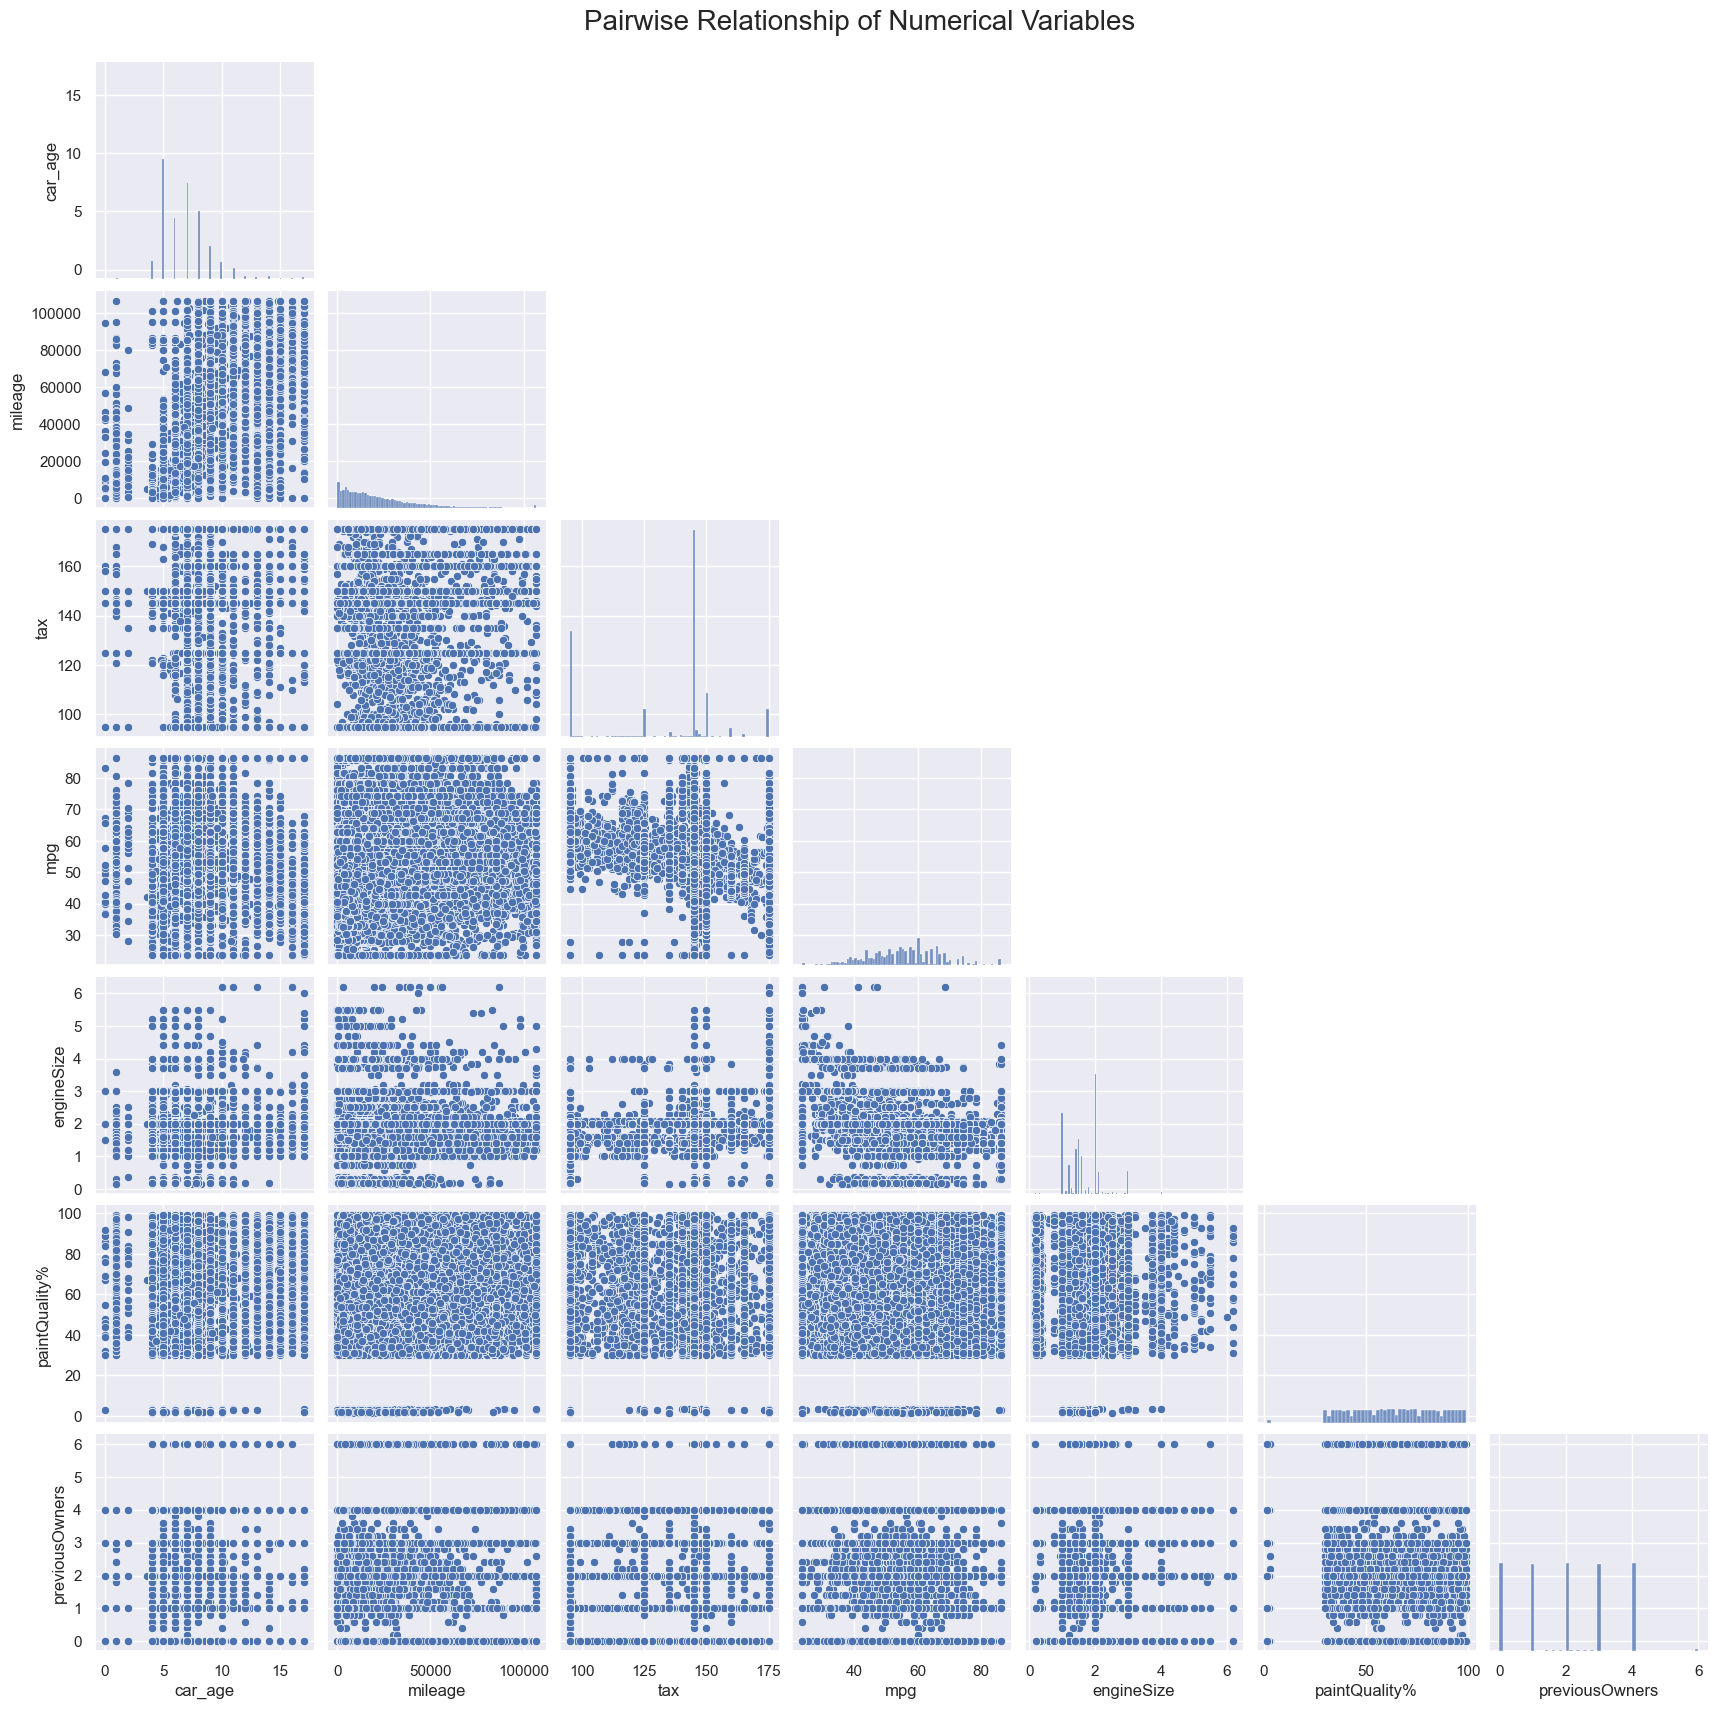

In [20]:
sns.set()

metric_features = X_train.select_dtypes(include=np.number)
g = sns.pairplot(metric_features)

# Mask the upper triangle
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)

plt.subplots_adjust(top=0.95)
plt.suptitle("Pairwise Relationship of Numerical Variables", fontsize=20)
plt.show()


Doesn't seem to have any significant multidimensional outliers.

## Encoding Categorical Variables
[Back to TOC](#toc)

Let's start by transforming the columns "Brand" and "model.

In [21]:
print("\n================= ANTES DO ENCODING =================")
print(X_train[["Brand", "model"]].head(10))
print("\nColunas iniciais:", X_train.columns.tolist())


================= ANTES DO ENCODING =================
      Brand model
carID            
1696   Audi    Q3
4757   Audi    A5
2943   Audi    A1
4670   Audi    A3
2761   Audi   Sq5
1238   Audi    A4
5360   Audi    A3
6532   Audi    Q2
3237   Audi    A6
6387   Audi    Q5

Colunas iniciais: ['Brand', 'model', 'car_age', 'transmission', 'mileage', 'fuelType', 'tax', 'mpg', 'engineSize', 'paintQuality%', 'previousOwners']


In [22]:
encoder_brand = OneHotEncoder(feature_name_combiner=custom_combiner, sparse_output=False)
encoded_brand = encoder_brand.fit_transform(X_train[["Brand"]])

# Convert encoded output to DataFrame (with feature names)
encoded_df_brand = pd.DataFrame(encoded_brand, columns=encoder_brand.get_feature_names_out(), index=X_train.index)

# Concatenate back with original (if you want)
X_train = pd.concat([X_train, encoded_df_brand], axis=1)

In [23]:
encoders_by_brand = {} # dictionary to store one LabelEncoder per brand

for brand in X_train["Brand"].unique().tolist():
    le = LabelEncoder()
    labels = le.fit_transform(X_train.loc[X_train["Brand"] == brand, "model"])
    X_train.loc[X_train[brand] == 1, brand] = labels
    encoders_by_brand[brand] = le  # save the encoder for this brand

In [24]:
X_train.drop(columns= ["Brand", "model"], inplace=True)

In [25]:
print("\n================= DEPOIS DO ENCODING =================")
print(X_train.head(10))
print("\nColunas finais:", X_train.columns.tolist())


================= DEPOIS DO ENCODING =================
       car_age transmission  mileage fuelType    tax   mpg  engineSize  \
carID                                                                    
1696       8.0       Manual  38578.0   Petrol   99.0  49.6    1.400000   
4757       5.0    Automatic    100.0   Diesel  145.0  47.1    2.000000   
2943      13.0       Manual  69145.0   Petrol  125.0  53.3    3.739235   
4670       7.8    Semi-Auto  43014.0   Diesel  125.0  57.6    2.000000   
2761       9.0    Automatic  51546.4   Diesel  175.0  41.5    3.000000   
1238       6.0    Semi-Auto  19288.0   Diesel  145.0  61.4    2.000000   
5360       5.0    Automatic   1500.0   Petrol  145.0  39.2    2.000000   
6532       5.0       Manual   2000.0   Diesel  145.0  49.6    1.600000   
3237       9.0    Semi-Auto  46482.0   Diesel  175.0  44.8    3.000000   
6387       9.0       Manual  24380.0   Diesel  175.0  47.9    2.000000   

       paintQuality%  previousOwners  Audi  BMW  Ford  

Now, we'll move on to encode "fuelType".

In [26]:
X_train["fuelType"].value_counts()

fuelType
Petrol    29862
Diesel    21494
Hybrid     1539
Other       120
Name: count, dtype: int64

In [27]:
encoder_fuelType = OneHotEncoder(feature_name_combiner=custom_combiner, sparse_output=False, drop = ["Other"])
encoded_fuelType = encoder_fuelType.fit_transform(X_train[["fuelType"]])

# Convert encoded output to DataFrame (with feature names)
encoded_df_fuelType = pd.DataFrame(encoded_fuelType, columns=encoder_fuelType.get_feature_names_out(), index=X_train.index)

# Concatenate back with original (if you want)
X_train = pd.concat([X_train, encoded_df_fuelType], axis=1)
X_train.drop("fuelType", axis= 1, inplace= True)

Finally, let's encode the column "transmission".

In [28]:
X_train["transmission"].value_counts()

transmission
Manual       30142
Semi-Auto    11700
Automatic    10660
Unknown        510
Other            3
Name: count, dtype: int64

--- 

ESTAMOS A REMOVER OS "OTHER" TEMPORÁRIAMENTE !!!!

--- 

In [29]:
indexes = X_train[X_train["transmission"] == "Other"].index.to_list()

X_train.drop(index=indexes, inplace=True)
y_train.drop(index=indexes, inplace=True)

--- 

ESTAMOS A REMOVER OS "OTHER" TEMPORÁRIAMENTE !!!!

--- 

In [30]:
#X_train = X_train.loc[~X_train["transmission"].isin(["Other"])] # removing the 3 rows with "Other"
encoder_transmission = OneHotEncoder(feature_name_combiner=custom_combiner, sparse_output=False, drop = ["Unknown"])
encoded_transmission = encoder_transmission.fit_transform(X_train[["transmission"]])

# Convert encoded output to DataFrame (with feature names)
encoded_df_transmission = pd.DataFrame(encoded_transmission, columns=encoder_transmission.get_feature_names_out(), index=X_train.index)

# Concatenate back with original (if you want)
X_train = pd.concat([X_train, encoded_df_transmission], axis=1)
X_train.drop("transmission", axis= 1, inplace= True)

In [31]:
X_train

,car_age,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,Audi,BMW,Ford,Hyundai,Mercedes,Opel,Skoda,Toyota,VW,Diesel,Hybrid,Petrol,Automatic,Manual,Semi-Auto
carID,,,,,,,,,,,,,,,,,,,,,,
1696,8.0,38578.0,99.0,49.6,1.400000,33.0,4.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4757,5.0,100.0,145.0,47.1,2.000000,38.0,4.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2943,13.0,69145.0,125.0,53.3,3.739235,76.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4670,7.8,43014.0,125.0,57.6,2.000000,41.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2761,9.0,51546.4,175.0,41.5,3.000000,59.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66597,5.0,53.0,150.0,36.2,1.500000,60.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,0.0,0.0,1.0,0.0,1.0,0.0
67737,4.0,3500.0,145.0,49.6,1.000000,85.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,1.0,0.0,1.0,0.0
74109,7.0,13752.0,150.0,42.8,3.000000,67.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,1.0,0.0,0.0,1.0,0.0,0.0


--- 

ENCODING DO VALIDATION

--- 

In [32]:
# ===========================================
# Load validation dataset (X_val)
# ===========================================

# Load validation data (note: path is relative to the notebook)
X_val = pd.read_csv("../data/X_val.csv", index_col="carID")

# Quick check
print("Validation data loaded successfully")
print("Shape:", X_val.shape)
print("\nColumns:", X_val.columns.tolist())

# Optional: preview
X_val.head()



Validation data loaded successfully
Shape: (22722, 11)

Columns: ['Brand', 'model', 'car_age', 'transmission', 'mileage', 'fuelType', 'tax', 'mpg', 'engineSize', 'paintQuality%', 'previousOwners']


,Brand,model,car_age,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners
carID,,,,,,,,,,,
47723,Skoda,Kamiq,5.0,Semi-Auto,4000.0,Petrol,NaN,44.1,1.5,74.0,2.0
2100,Audi,A3,5.0,Automatic,4680.0,Diesel,145.0,52.3,1.6,84.0,2.0
29349,Ford,Fiesta,9.0,Manual,NaN,Petrol,125.0,54.3,1.2,44.0,4.0
8735,BMW,8 series,9.0,Automatic,69758.0,Diesel,125.0,60.1,2.0,94.0,1.0
18705,Ford,Focus,9.0,Manual,28000.0,Petrol,NaN,NaN,NaN,56.0,1.0


In [33]:

# STEP 1: Apply only the OneHotEncoder from Brand (used in the train).


print("\n================= BEFORE ENCODING (X_val) =================")
print(X_val[["Brand"]].head(10))
print("\nInitial columns:", X_val.columns.tolist())

# ---- Apply the trained encoder on train ----
encoded_val_brand = encoder_brand.transform(X_val[["Brand"]])

# Create a DataFrame with the column names the same as in the training file.
encoded_df_val_brand = pd.DataFrame(
    encoded_val_brand,
    columns=[col.replace("Brand_", "") for col in encoder_brand.get_feature_names_out()],
    index=X_val.index
)

# concatenar com X_val
X_val = pd.concat([X_val, encoded_df_val_brand], axis=1)

print("\n================= DEPOIS DO ENCODING (Brand) =================")
print(X_val.head(10))
print("\nColunas finais:", X_val.columns.tolist())



================= BEFORE ENCODING (X_val) =================
         Brand
carID         
47723    Skoda
2100      Audi
29349     Ford
8735       BMW
18705     Ford
52680   Toyota
60212     Opel
23957     Ford
33908  Hyundai
9930       BMW

Initial columns: ['Brand', 'model', 'car_age', 'transmission', 'mileage', 'fuelType', 'tax', 'mpg', 'engineSize', 'paintQuality%', 'previousOwners']

================= DEPOIS DO ENCODING (Brand) =================
         Brand     model  car_age transmission  mileage fuelType    tax   mpg  \
carID                                                                           
47723    Skoda     Kamiq      5.0    Semi-Auto   4000.0   Petrol    NaN  44.1   
2100      Audi        A3      5.0    Automatic   4680.0   Diesel  145.0  52.3   
29349     Ford    Fiesta      9.0       Manual      NaN   Petrol  125.0  54.3   
8735       BMW  8 series      9.0    Automatic  69758.0   Diesel  125.0  60.1   
18705     Ford     Focus      9.0       Manual  28000.0   P

In [34]:
print("\n================= ENCODING MAPS PER BRAND =================")

for brand, le in encoders_by_brand.items():
    mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(f"\n{brand}:")
    for model, code in mapping.items():
        print(f"  {model:20s} -> {code}")



================= ENCODING MAPS PER BRAND =================

Audi:
  A                    -> 0
  A class              -> 1
  A1                   -> 2
  A2                   -> 3
  A3                   -> 4
  A4                   -> 5
  A5                   -> 6
  A6                   -> 7
  A7                   -> 8
  A8                   -> 9
  Q                    -> 10
  Q2                   -> 11
  Q3                   -> 12
  Q5                   -> 13
  Q7                   -> 14
  Q8                   -> 15
  R8                   -> 16
  Rs                   -> 17
  Rs3                  -> 18
  Rs4                  -> 19
  Rs5                  -> 20
  Rs6                  -> 21
  S3                   -> 22
  S4                   -> 23
  S5                   -> 24
  S8                   -> 25
  Sq5                  -> 26
  Sq7                  -> 27
  T                    -> 28
  Tt                   -> 29

BMW:
  1 series             -> 0
  2 serie              -> 1
  4 series

In [35]:
# ===========================================
# STEP 2: Apply label encoding of 'model' in X_val (using encoders from train, no fit)
# ===========================================

print("\n================= BEFORE MODEL ENCODING (X_val) =================")
print(X_val[["Brand", "model"]].head(10))

# Confirm available encoders from training
print("\nEncoders available from training:", list(encoders_by_brand.keys()))

# Loop over each brand in the validation dataset
for brand in X_val["Brand"].unique().tolist():

    # Only process if the brand exists in the training encoders
    if brand in encoders_by_brand:
        le = encoders_by_brand[brand]     # Use the pre-fitted encoder
        mask = X_val["Brand"] == brand
        models_val = X_val.loc[mask, "model"]

        # Identify which models are known (seen during training)
        known_models = set(le.classes_)
        known_mask = models_val.isin(known_models)
        unknown_mask = ~known_mask

        # Encode only the known models
        if known_mask.sum() > 0:
            X_val.loc[mask & known_mask, brand] = le.transform(models_val[known_mask])
            print(f"{brand}: {known_mask.sum()} known models encoded successfully.")

        # Assign 0 to unseen models (not present during training)
        if unknown_mask.sum() > 0:
            unseen_models = set(models_val[unknown_mask].unique())
            print(f"{brand}: {unknown_mask.sum()} unseen models -> {unseen_models}")
            X_val.loc[mask & unknown_mask, brand] = 0

    # If the brand does not exist in training encoders, assign 0 to all rows of that brand
    else:
        print(f"{brand}: brand not present in training encoders.")
        X_val.loc[X_val["Brand"] == brand, brand] = 0

# Drop original 'Brand' and 'model' columns (not needed after encoding)
X_val.drop(columns=["Brand", "model"], inplace=True)

print("\n================= AFTER MODEL ENCODING (X_val) =================")
print(X_val.head(10))
print("\nFinal columns:", X_val.columns.tolist())



================= BEFORE MODEL ENCODING (X_val) =================
         Brand     model
carID                   
47723    Skoda     Kamiq
2100      Audi        A3
29349     Ford    Fiesta
8735       BMW  8 series
18705     Ford     Focus
52680   Toyota     Yaris
60212     Opel      Mokk
23957     Ford     Focus
33908  Hyundai     Ioniq
9930       BMW        X1

Encoders available from training: ['Audi', 'BMW', 'Ford', 'Hyundai', 'Mercedes', 'Opel', 'Skoda', 'Toyota', 'VW']
Skoda: 1290 known models encoded successfully.
Skoda: 24 unseen models -> {nan}
Audi: 2204 known models encoded successfully.
Audi: 35 unseen models -> {nan}
Ford: 4820 known models encoded successfully.
Ford: 91 unseen models -> {nan, 'Ranger'}
BMW: 2204 known models encoded successfully.
BMW: 38 unseen models -> {nan, 'I'}
Toyota: 1381 known models encoded successfully.
Toyota: 30 unseen models -> {nan}
Opel: 2810 known models encoded successfully.
Opel: 47 unseen models -> {nan}
Hyundai: 996 known models encod

In [36]:
X_val.sample(100, random_state=7)[["Audi", "BMW", "Ford", "Hyundai", "Mercedes", "Opel", "Skoda", "Toyota", "VW"]]


,Audi,BMW,Ford,Hyundai,Mercedes,Opel,Skoda,Toyota,VW
carID,,,,,,,,,
56205,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0
67363,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0
70758,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
62601,0.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0
58735,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
60818,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0
67343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0


fuelType

In [37]:
# ===========================================
# STEP: Apply OneHotEncoder for 'fuelType' (using encoder from train)
# ===========================================

print("\n================= BEFORE ENCODING fuelType (X_val) =================")
print(X_val["fuelType"].value_counts())

# Apply the encoder trained on X_train
encoded_val_fuel = encoder_fuelType.transform(X_val[["fuelType"]])

# Create DataFrame with same column names and index
encoded_df_val_fuel = pd.DataFrame(
    encoded_val_fuel,
    columns=encoder_fuelType.get_feature_names_out(),
    index=X_val.index
)

# Concatenate encoded columns to X_val
X_val = pd.concat([X_val, encoded_df_val_fuel], axis=1)

# Drop the original column
X_val.drop("fuelType", axis=1, inplace=True)

print("\n================= AFTER ENCODING fuelType (X_val) =================")
print(X_val.head(10))
print("\nColumns after fuelType encoding:", X_val.columns.tolist())



================= BEFORE ENCODING fuelType (X_val) =================
fuelType
Petrol    12320
Diesel     9255
Hybrid      674
Other        47
Name: count, dtype: int64


ValueError: Found unknown categories [nan] in column 0 during transform

In [ ]:
# ===========================================
# STEP: Apply OneHotEncoder for 'transmission' (using encoder from train)
# ===========================================

print("\n================= BEFORE ENCODING transmission (X_val) =================")
print(X_val["transmission"].value_counts())

# Remove rows with 'Other' to match training behavior
indexes_to_drop = X_val[X_val["transmission"] == "Other"].index.to_list()
X_val.drop(index=indexes_to_drop, inplace=True)
y_val.drop(index=indexes_to_drop, inplace=True)

# Apply the encoder trained on X_train
encoded_val_transmission = encoder_transmission.transform(X_val[["transmission"]])

# Create DataFrame with same column names and index
encoded_df_val_transmission = pd.DataFrame(
    encoded_val_transmission,
    columns=encoder_transmission.get_feature_names_out(),
    index=X_val.index
)

# Concatenate encoded columns to X_val
X_val = pd.concat([X_val, encoded_df_val_transmission], axis=1)

# Drop the original column
X_val.drop("transmission", axis=1, inplace=True)

print("\n================= AFTER ENCODING transmission (X_val) =================")
print(X_val.head(10))
print("\nColumns after transmission encoding:", X_val.columns.tolist())


## Feature Engeneering
[Back to TOC](#toc)

In [ ]:
X_train

,Brand,model,car_age,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,Audi,BMW,Ford,Hyundai,Mercedes,Opel,Skoda,Toyota,VW,Diesel,Hybrid,Petrol,Automatic,Manual,Semi-Auto
carID,,,,,,,,,,,,,,,,,,,,,,,,
1696,Audi,Q3,8.0,38578.0,99.0,49.6,1.400000,33.0,4.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4757,Audi,A5,5.0,100.0,145.0,47.1,2.000000,38.0,4.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2943,Audi,A1,13.0,69145.0,125.0,53.3,3.739235,76.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4670,Audi,A3,7.8,43014.0,125.0,57.6,2.000000,41.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2761,Audi,Sq5,9.0,51546.4,175.0,41.5,3.000000,59.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66597,VW,Tiguan allspace,5.0,53.0,150.0,36.2,1.500000,60.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,0.0,0.0,1.0,0.0,1.0,0.0
67737,VW,Polo,4.0,3500.0,145.0,49.6,1.000000,85.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,1.0,0.0,1.0,0.0
74109,VW,Touareg,7.0,13752.0,150.0,42.8,3.000000,67.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,1.0,0.0,0.0,1.0,0.0,0.0


## Data Scaling
[Back to TOC](#toc)

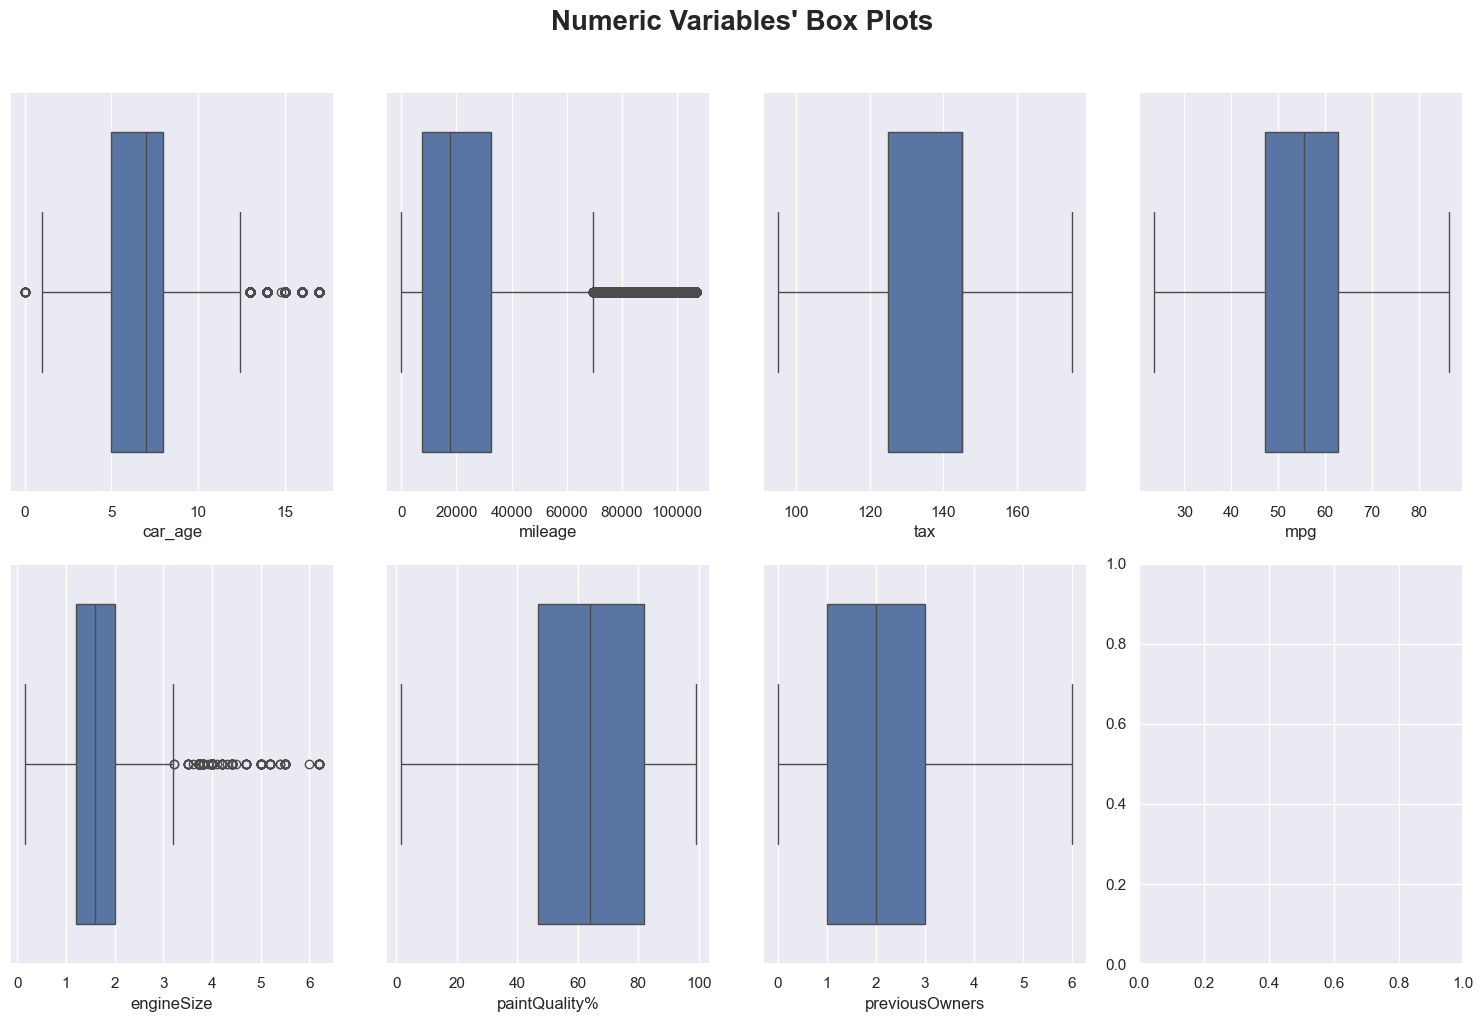

In [ ]:
boxplotter(X_train, metric_features = X_train[["car_age", "mileage", "tax", "mpg", "engineSize", "paintQuality%", "previousOwners"]], n_rows=2, n_cols=4)

As there are a three variables with skewed distributions, which contain outliers, but these are not removed as they represent important insights, the best scaler to use is the Robust scaler, as this scaler leads better with outliers.

In [ ]:
scaler = RobustScaler()

X_train_num = X_train[["car_age", "mileage", "tax",	"mpg", "engineSize", "paintQuality%", "previousOwners"]]

#fit and transform the data
X_train_num_scaled = scaler.fit_transform(X_train_num)

# Convert the array to a pandas dataframe
X_train_num_scaled = pd.DataFrame(X_train_num_scaled, columns = X_train_num.columns).set_index(X_train_num.index)
X_train_num_scaled

,car_age,mileage,tax,mpg,engineSize,paintQuality%,previousOwners
carID,,,,,,,
1696,0.333333,0.849075,-2.30,-0.369427,-0.250000,-0.885714,1.0
4757,-0.666667,-0.704823,0.00,-0.528662,0.500000,-0.742857,1.0
2943,2.000000,2.083494,-1.00,-0.133758,2.674044,0.342857,-1.0
4670,0.266667,1.028218,-1.00,0.140127,0.500000,-0.657143,0.5
2761,0.666667,1.372791,1.50,-0.885350,1.750000,-0.142857,-1.0
...,...,...,...,...,...,...,...
66597,-0.666667,-0.706721,0.25,-1.222930,-0.125000,-0.114286,-0.5
67737,-1.000000,-0.567517,0.00,-0.369427,-0.750000,0.600000,0.5
74109,0.000000,-0.153500,0.25,-0.802548,1.750000,0.085714,0.0


In [ ]:
num_cols = ["car_age", "mileage", "tax", "mpg", "engineSize", "paintQuality%", "previousOwners"]
X_train_cat = X_train.drop(columns=num_cols)
X_train_cat

,Brand,model,Audi,BMW,Ford,Hyundai,Mercedes,Opel,Skoda,Toyota,VW,Diesel,Hybrid,Petrol,Automatic,Manual,Semi-Auto
carID,,,,,,,,,,,,,,,,,
1696,Audi,Q3,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4757,Audi,A5,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2943,Audi,A1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4670,Audi,A3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2761,Audi,Sq5,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66597,VW,Tiguan allspace,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,0.0,0.0,1.0,0.0,1.0,0.0
67737,VW,Polo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,1.0,0.0,1.0,0.0
74109,VW,Touareg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,1.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
X_train_scaled = pd.merge(X_train_num_scaled, X_train_cat, on = "carID", how= "inner")
X_train_scaled

,car_age,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,Brand,model,Audi,BMW,Ford,Hyundai,Mercedes,Opel,Skoda,Toyota,VW,Diesel,Hybrid,Petrol,Automatic,Manual,Semi-Auto
carID,,,,,,,,,,,,,,,,,,,,,,,,
1696,0.333333,0.849075,-2.30,-0.369427,-0.250000,-0.885714,1.0,Audi,Q3,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4757,-0.666667,-0.704823,0.00,-0.528662,0.500000,-0.742857,1.0,Audi,A5,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2943,2.000000,2.083494,-1.00,-0.133758,2.674044,0.342857,-1.0,Audi,A1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4670,0.266667,1.028218,-1.00,0.140127,0.500000,-0.657143,0.5,Audi,A3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2761,0.666667,1.372791,1.50,-0.885350,1.750000,-0.142857,-1.0,Audi,Sq5,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66597,-0.666667,-0.706721,0.25,-1.222930,-0.125000,-0.114286,-0.5,VW,Tiguan allspace,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,0.0,0.0,1.0,0.0,1.0,0.0
67737,-1.000000,-0.567517,0.00,-0.369427,-0.750000,0.600000,0.5,VW,Polo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,1.0,0.0,1.0,0.0
74109,0.000000,-0.153500,0.25,-0.802548,1.750000,0.085714,0.0,VW,Touareg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,1.0,0.0,0.0,1.0,0.0,0.0


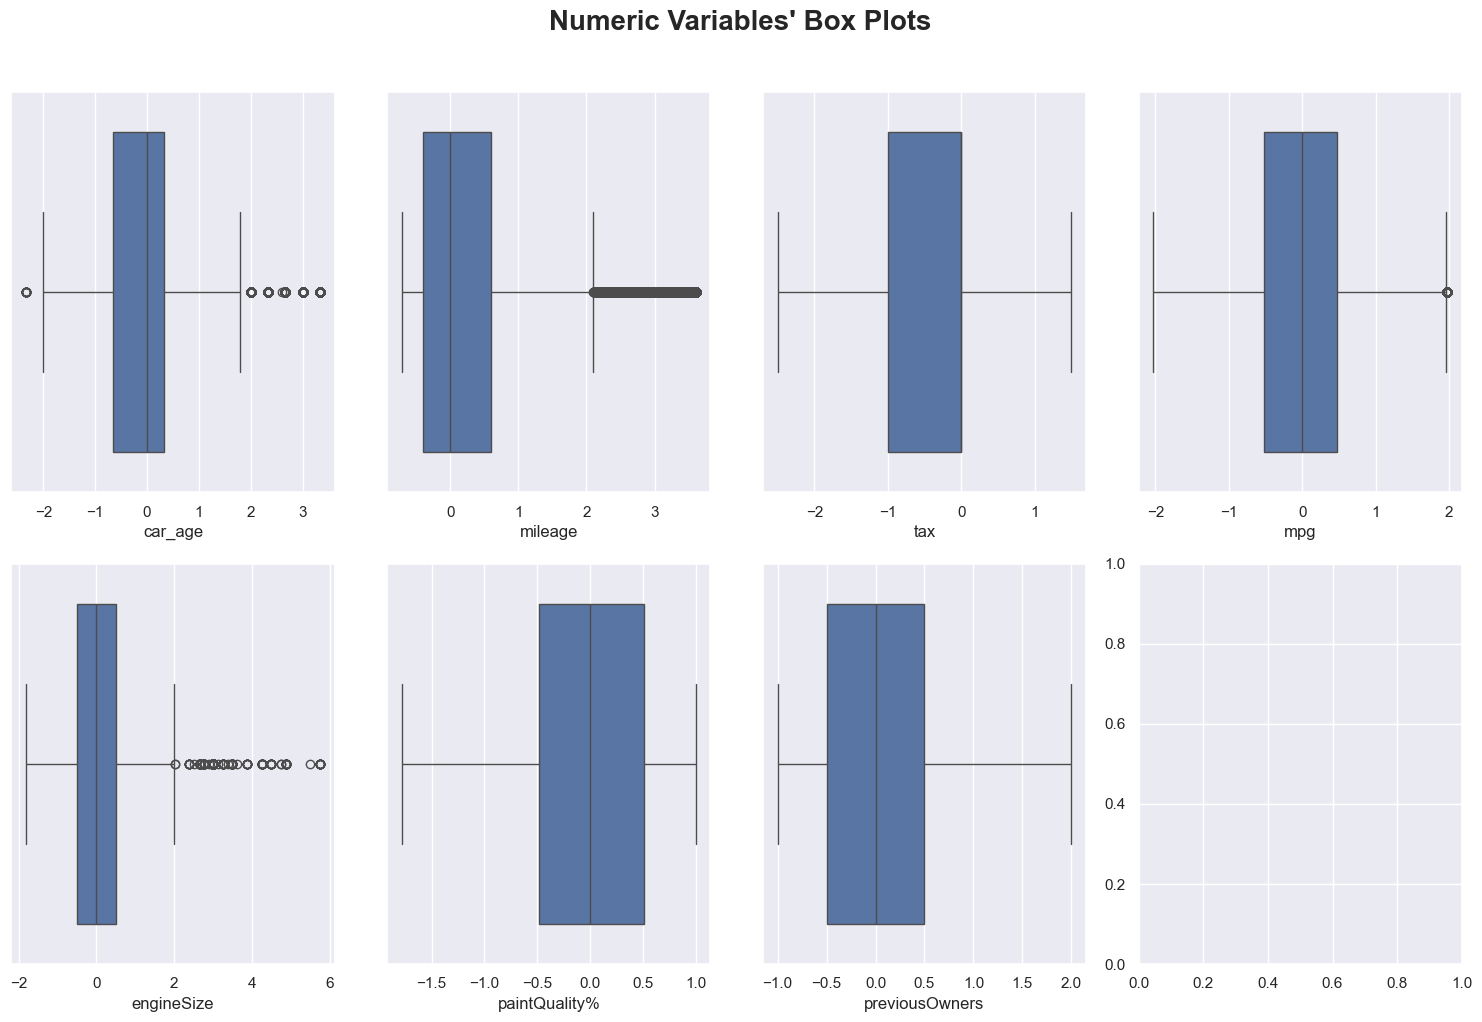

In [ ]:
boxplotter(X_train_scaled, metric_features = X_train_scaled[["car_age", "mileage", "tax", "mpg", "engineSize", "paintQuality%", "previousOwners"]], n_rows=2, n_cols=4)

Exporting the train data.

In [ ]:
X_train_scaled.to_csv("/Users/miguelmatos/Documents/GitHub/Machine_Learning_project/ML_Project_Group42/data/X_train.csv")
y_train.to_csv("/Users/miguelmatos/Documents/GitHub/Machine_Learning_project/ML_Project_Group42/data/y_train.csv")

OSError: Cannot save file into a non-existent directory: '/Users/miguelmatos/Documents/GitHub/Machine_Learning_project/ML_Project_Group42/data'

Exporting the validation data.

In [ ]:
X_val.to_csv("/Users/miguelmatos/Documents/GitHub/Machine_Learning_project/ML_Project_Group42/data/X_val.csv")
y_val.to_csv("/Users/miguelmatos/Documents/GitHub/Machine_Learning_project/ML_Project_Group42/data/y_val.csv")